In [1]:

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

import yaml


/home/saurabh.nair/giant_nerfs/pytorch-superpoint-new


In [2]:
from models.model_wrap import SuperPointFrontend_torch

In [3]:
config_path = os.path.expanduser("~/giant_nerfs/pytorch-superpoint-new/configs/giant_exps.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
print(config)
weights_path = config["model"]["pretrained"]
nms_dist = config["model"]["nms"]
conf_thresh = config["model"]["detection_threshold"]
nn_thresh = 0.7
device = 'cuda'

{'data': {'name': 'patches_dataset', 'dataset': 'hpatches', 'alteration': 'all', 'preprocessing': {'resize': [240, 320]}}, 'front_end_model': 'Val_model_heatmap', 'model': {'name': 'SuperPointNet_gauss2', 'params': {}, 'detection_threshold': 0.015, 'batch_size': 1, 'eval_batch_size': 1, 'learning_rate': 0.001, 'nms': 4, 'top_k': 1000, 'nn_thresh': 1.0, 'homography_adaptation': {'num': 0}, 'subpixel': {'enable': False, 'patch_size': 5}, 'rand_noise': {'enable': False, 'sigma': 0.2}, 'pretrained': '/scratch/aiscience/logs/superpoint/superpoint_coco/checkpoints/superPointNet_189800_checkpoint.pth.tar'}, 'eval_iter': 1000}


In [4]:
sp_fe = SuperPointFrontend_torch(
    config=config,
    weights_path=weights_path,
    nms_dist=nms_dist,
    conf_thresh=conf_thresh,
    nn_thresh=nn_thresh,
    cuda=False,
    device=device,
)

sp_fe.net_parallel()

model:  SuperPointNet_gauss2
=== Let's use 3 GPUs!


In [5]:
from PIL import Image
import numpy as np

In [6]:
image_data_path = "/scratch/aiscience/data/combined_setx/set_0/images/"

In [38]:
rgb_img = Image.open(os.path.join(image_data_path, "IMG_2044.jpg"))
img = rgb_img.convert('L')
newsize = (1280, 960)
img = img.resize(newsize)

In [39]:
image_np = np.asarray(img) / 255.0


In [40]:
import torch

In [41]:
image_torch = torch.from_numpy(image_np)

In [42]:
image_torch = image_torch.transpose(1, 0)

In [43]:
image_torch = image_torch[None, None, :]
image_torch = image_torch.to(device, dtype=torch.float)

In [44]:
output = sp_fe.run(image_torch, onlyHeatmap=True, train=False)

In [45]:
output_heatmap = output.to("cpu").numpy()

output_heatmap = np.squeeze(output_heatmap, axis=0)
output_heatmap = np.squeeze(output_heatmap, axis=0)

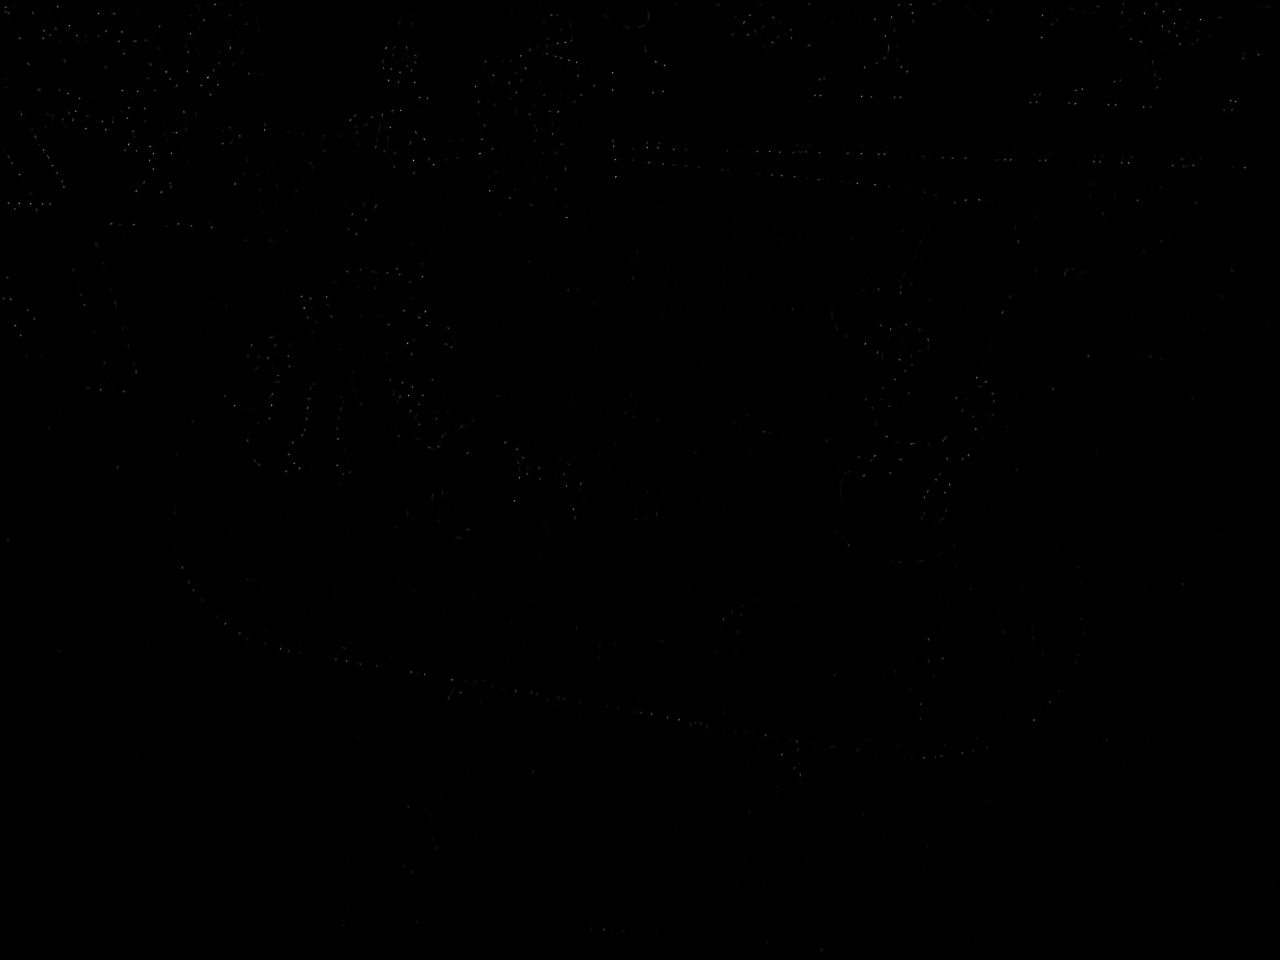

In [46]:
Image.fromarray(np.uint8(output_heatmap * 255).T, "L")

In [47]:
keypoint_locations = sp_fe.getPtsFromHeatmap(output.detach().cpu().squeeze())

In [48]:
keypoint_locations = keypoint_locations.transpose()

In [49]:
#rgb_img
newsize = (1280, 960)
rgb_img = rgb_img.resize(newsize)

In [50]:
keypoint_locations.shape

(1330, 3)

In [51]:
keypoint_locations[4]

array([1.90000000e+01, 1.20000000e+03, 5.82321584e-01])

In [64]:
rgb_img_array = np.array(rgb_img)
blob_size = 2
blob = np.tile(np.array([0., 255, 0.]), (2*blob_size, 2*blob_size, 1))
for keypoint_location in keypoint_locations:
    rgb_img_array[
        int(keypoint_location[0]) - blob_size:int(keypoint_location[0]) + blob_size, 
        int(keypoint_location[1]) - blob_size:int(keypoint_location[1]) + blob_size
    ] = blob

In [65]:
rgb_img_with_pts = Image.fromarray(rgb_img_array)

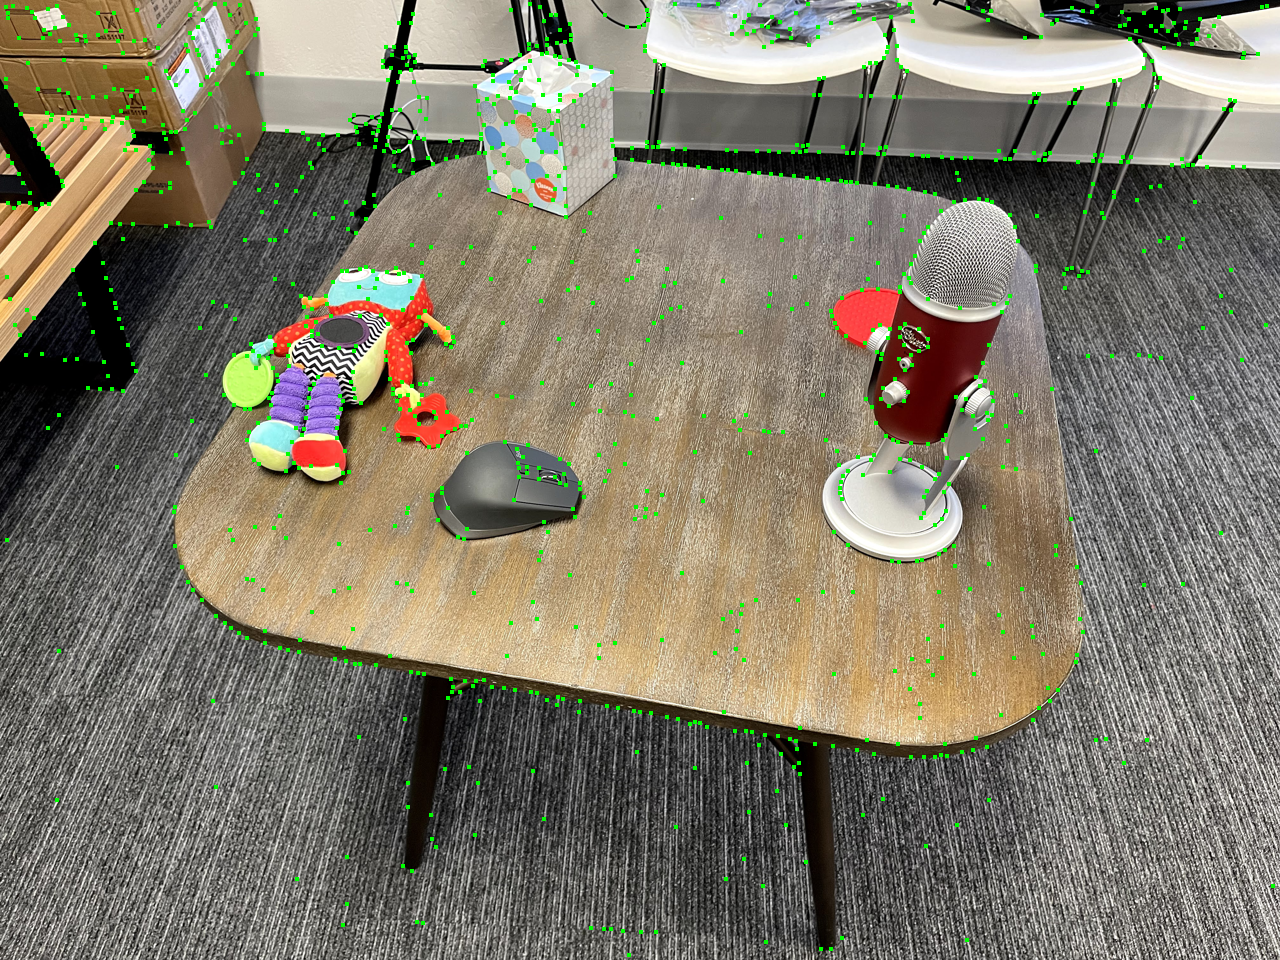

In [66]:
rgb_img_with_pts

In [67]:
output = sp_fe.run(image_torch, onlyHeatmap=False, train=False)

In [68]:
pts, pts_desc, dense_desc, heatmap = output

In [69]:
pts_desc[0].shape

(256, 1330)